Phil McCormick

MSDS 599 

April 11, 2022

Homework 3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [4]:
from sklearn import tree
from sklearn.tree import export_text

1. Read in this file. How many classes are there? How many features are there? Are there any missing entries? 


In [5]:
df=pd.read_csv('/content/drive/MyDrive/Data 599/classify_me.csv')
df.head()

,Unnamed: 0,A,B,C,D,E,F,G,H,I,J,Target
0,0,0.150333,-1.468600,0.420842,-0.878333,-1.348358,0.686323,-0.663374,-2.301067,1.302455,0.320666,2
1,1,-1.632086,-0.705800,0.336495,0.024062,-0.493619,-1.534829,-0.024577,-0.296786,0.320047,0.506105,1
2,2,-1.285627,1.381077,-0.385668,1.446167,-0.348163,-2.255813,0.272703,-0.964729,-1.515589,0.454248,2
3,3,-0.012135,-0.729971,-1.132579,1.076787,1.235348,1.234472,-1.809369,0.735971,-1.349093,-0.061655,0
4,4,-1.303877,0.930213,0.801927,-1.750493,0.846840,-0.258996,-0.507816,0.560169,0.583438,-0.472208,0


In [6]:
df.nunique()

Unnamed: 0    1000
A             1000
B             1000
C             1000
D             1000
E             1000
F             1000
G             1000
H             1000
I             1000
J             1000
Target           3
dtype: int64

In [7]:
df.dtypes

Unnamed: 0      int64
A             float64
B             float64
C             float64
D             float64
E             float64
F             float64
G             float64
H             float64
I             float64
J             float64
Target          int64
dtype: object

In [8]:
df.isna().sum()

Unnamed: 0    0
A             0
B             0
C             0
D             0
E             0
F             0
G             0
H             0
I             0
J             0
Target        0
dtype: int64

There are three classes in the "Target" column; 0, 1, and 2. There are 10 different features to the "Target"; "A" through "J". There are no missing entries in the data set.

2. Split into training and test sets (30% test set). Use random_state=5 so your splits are reproducible. 

In [9]:
x=df.drop('Target',axis=1)
y=df['Target']

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=5)

3. Use all the features to build a classifier on the training set. Try bagging, random forest, boosting, and k-nearest neighbors. For knn, cross validate the number of neighbors you use. In your random forest implementation, build the trees deep -- that is, do not set a value for max_depth. For bagging and random forest,  cross validate the number of trees you use (given by the n_estimators parameter). For your boosting model, validate all of the parameters: n_estimators, learning_rate, and max_depth. In all three models, set random_state=5 so the results are reproducible.

KNN

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

In [12]:
cvres=[]
for i in range(1,100):
    clf = KNeighborsClassifier(n_neighbors=i)
    nn = cross_validate(clf, x_train, y_train, cv=5, scoring='accuracy')
    cvres.append(nn['test_score'].mean())

In [13]:
nn['test_score']

array([0.34285714, 0.3       , 0.35      , 0.36428571, 0.35714286])

In [14]:
np.argmax(cvres)

31

In [15]:
mod = KNeighborsClassifier(n_neighbors=32)
cl32=mod.fit(x_train,y_train)

In [16]:
cvres[20:35]

[0.3271428571428571,
 0.3442857142857143,
 0.35285714285714287,
 0.3442857142857143,
 0.35142857142857137,
 0.36571428571428577,
 0.36142857142857143,
 0.3728571428571429,
 0.36714285714285716,
 0.3557142857142857,
 0.3742857142857142,
 0.3771428571428571,
 0.36428571428571427,
 0.36142857142857143,
 0.3642857142857142]

In [17]:
accuracy_score(cl32.predict(x_test),y_test)

0.33666666666666667

Bagging

In [18]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [19]:
num_trees=np.linspace(50,800,10)

In [20]:
oob_res=[]
for trs in num_trees:
    res = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=int(trs),oob_score=True, random_state=5).fit(x_train, y_train)
    oob_res.append(res.oob_score_)

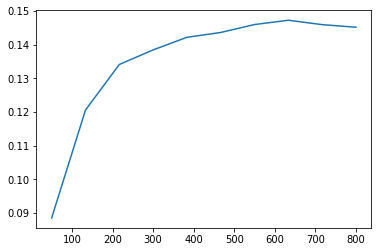

In [21]:
plt.plot(num_trees,oob_res)

In [22]:
num_trees[np.argmax(oob_res)]

633.3333333333333

In [23]:
opt_trs=int(num_trees[np.argmax(oob_res)])
opt_trs

633

In [24]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=opt_trs,random_state=5).fit(x_train, y_train)

In [25]:
accuracy_score(clf.predict(x_test),y_test)

0.6266666666666667

Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(n_estimators=opt_trs, max_features='sqrt', random_state=5).fit(x_train,y_train)

In [28]:
rf.score(x_test,y_test)

0.6433333333333333

Boosting

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [30]:
parameters = {'learning_rate':[0.1,0.01], 'n_estimators':[300,400,500], 'max_depth':[2,3,4,5]}

In [31]:
bmod = GradientBoostingClassifier(random_state=5)

In [32]:
boost_regr = GridSearchCV(bmod, parameters)
boost_regr.fit(x_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=5),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [300, 400, 500]})

In [38]:
df=pd.DataFrame.from_dict(boost_regr.cv_results_)

In [39]:
df[df['mean_test_score']==df['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,2.599049,0.028512,0.004412,0.000121,0.1,2,500,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.742857,0.7,0.735714,0.735714,0.75,0.732857,0.017261,1


In [40]:
breg = GradientBoostingClassifier(random_state=5,learning_rate=0.1,n_estimators=500, max_depth=2).fit(x_train,y_train)

In [41]:
breg.score(x_test,y_test)

0.69


4. Comment on which model gives the best results on the test set.  For the best model, comment on feature importances (if relevant).

The best results are given from the Boosting Regressor Model, with an accuracy score of 69% on the test set. We find the optimal parameters by creating a dataframe of cross validation scores and pick the best parameters for our model. Setting a low learning rate (0.1) allows for more trees to fit with residuals, and when combined make the model stronger. For this model it is best to not let the trees go to far, using a max depth of 2 gives us the best results. With a larger amount of estimators, 500, we get the strongest R^2.